# Stock market forecasting using Time Series analysis

**Here in this notebook to forecast the stock price of MIRCROSOFT using ARIMA model**

### What is ARIMA?
Autoregressive Integrated Moving Average (ARIMA) Model converts non-stationary data to stationary data before working on it. It is one of the most popular models to predict linear time series data.


ARIMA model has been used extensively in the field of finance and economics as it is known to be robust, efficient and has a strong potential for short-term share market prediction.



### Load all the required libraries

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
stock_data = pd.read_csv('data/MSFT.csv')
stock_data.set_index('Date', inplace=True)

In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-08,30.280001,30.879999,30.240000,30.660000,23.170244,51197400
2010-01-11,30.709999,30.760000,30.120001,30.270000,22.875513,68754700
2010-01-12,30.150000,30.400000,29.910000,30.070000,22.724375,65912100
2010-01-13,30.260000,30.520000,30.010000,30.350000,22.935970,51863500
2010-01-14,30.309999,31.100000,30.260000,30.959999,23.396961,63228100
...,...,...,...,...,...,...
2024-06-28,453.070007,455.380005,446.410004,446.950012,446.950012,28362300
2024-07-01,448.660004,457.369995,445.660004,456.730011,456.730011,17662800
2024-07-02,453.200012,459.589996,453.109985,459.279999,459.279999,13979800


Visualize the per day closing price of the stock.

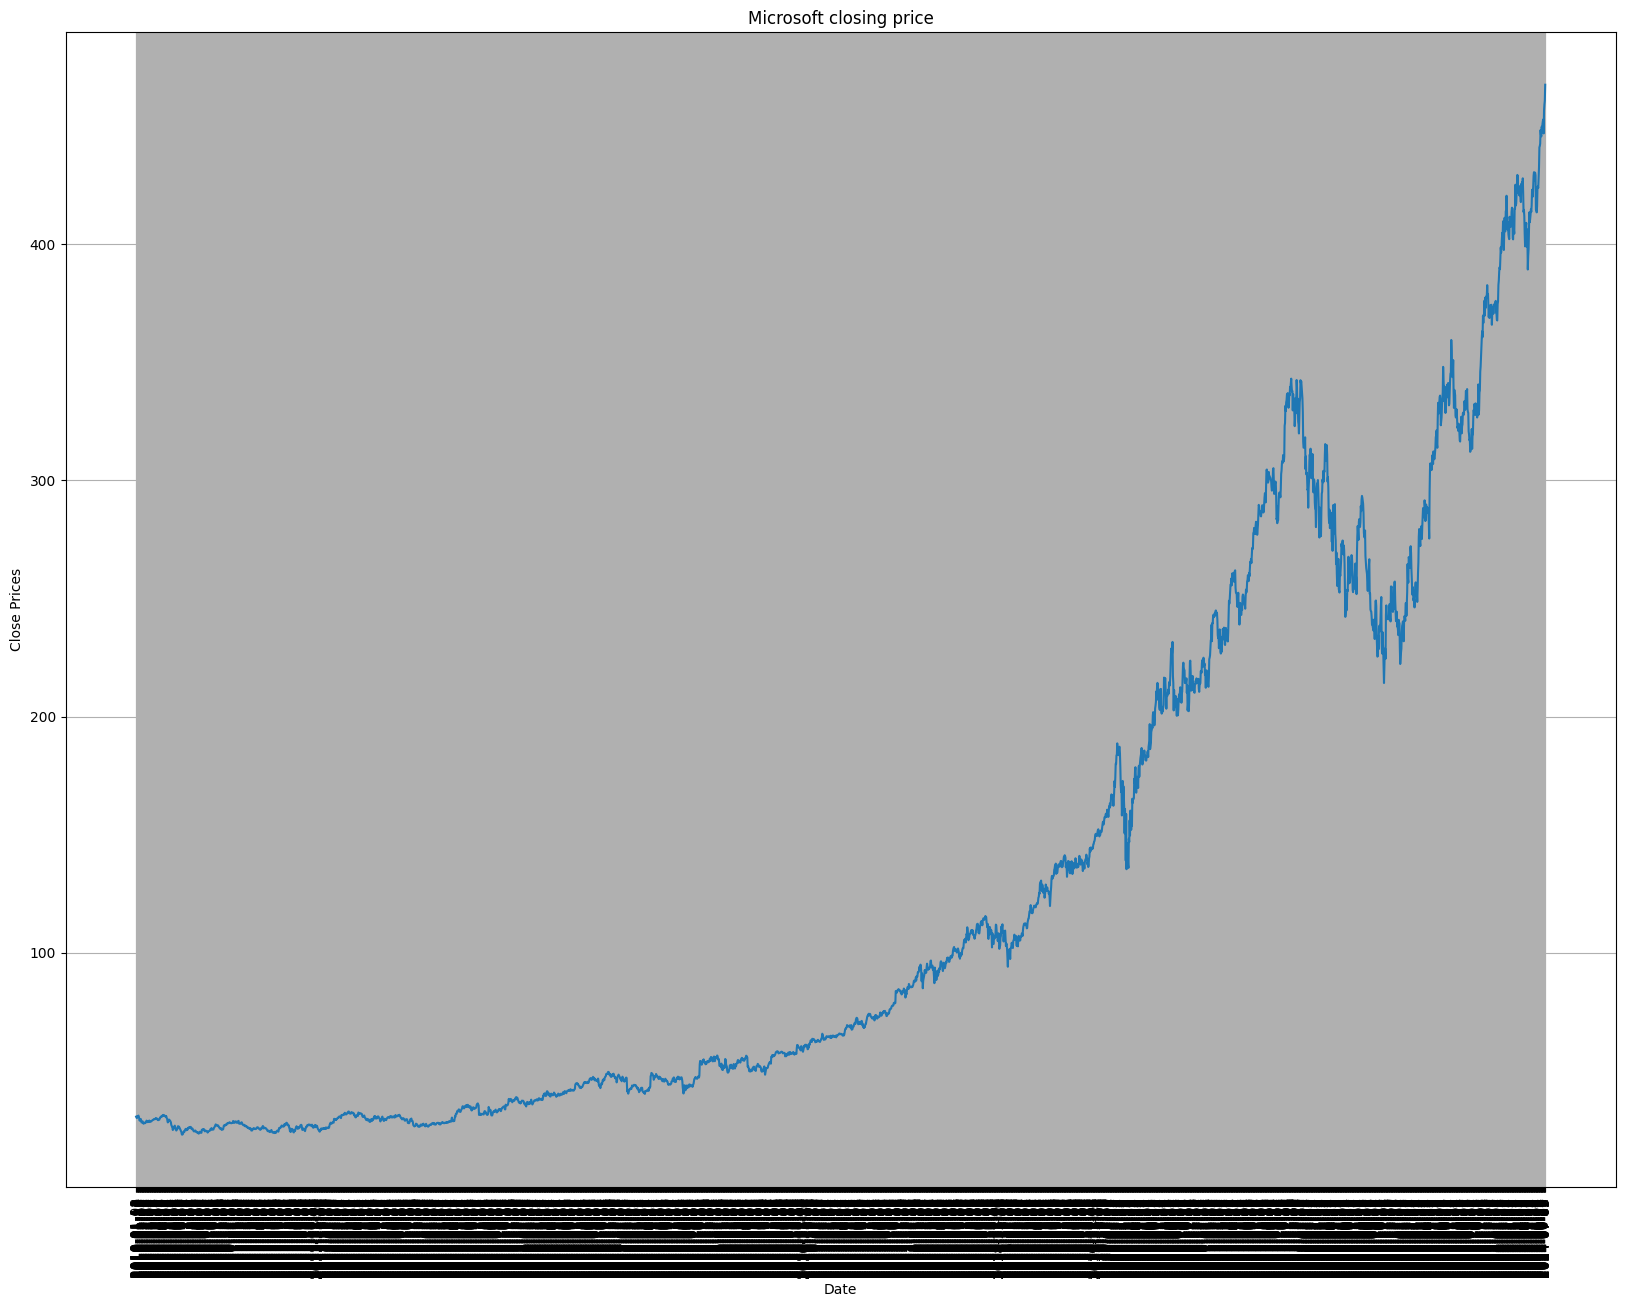

In [4]:
#plot close price
plt.figure(figsize=(20,15))
plt.grid(True)
plt.xlabel('Date')
plt.xticks(rotation = 90)
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('Microsoft closing price')
plt.show()

### We can also visualize the data in our series through a probability distribution too.

<Axes: ylabel='Density'>

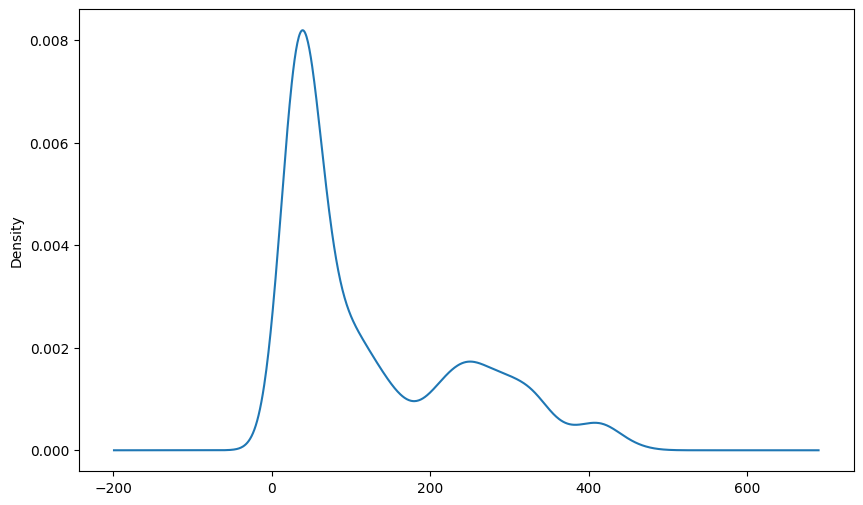

In [5]:
#Distribution of the dataset
stock_data['Close'].plot(kind='kde')

Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

1. **Level**: The average value in the series.

2. **Trend**: The increasing or decreasing value in the series.

3. **Seasonality**: The repeating short-term cycle in the series.

4. **Noise**: The random variation in the series.

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.


**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:


**Null Hypothesis**: The series has a unit root (value of a =1)


**Alternate Hypothesis**: The series has no unit root.


If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.


If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

### Or in short, if p-value < 0.05 we can say that time series is stationary

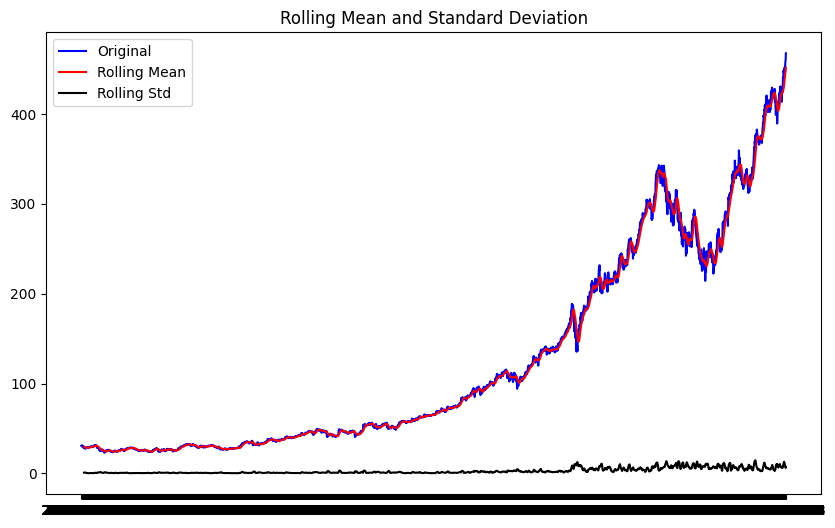

Results of Dickey Fuller test
Test Statistics                   3.093957
p-value                           1.000000
No. of lags used                 26.000000
Number of observations used    3619.000000
critical value (1%)              -3.432158
critical value (5%)              -2.862339
critical value (10%)             -2.567195
dtype: float64


In [6]:

def test_stationarity(timeseries):
    #Determing rolling statistics of past 15 days
    rolmean = timeseries.rolling(15).mean()
    rolstd = timeseries.rolling(15).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of Dickey Fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(stock_data['Close'])

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.


### In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.


So let us separate Trend and Seasonality from the time series.

Stationary because p-value = 2.320556420297035e-28


<Figure size 1000x600 with 0 Axes>

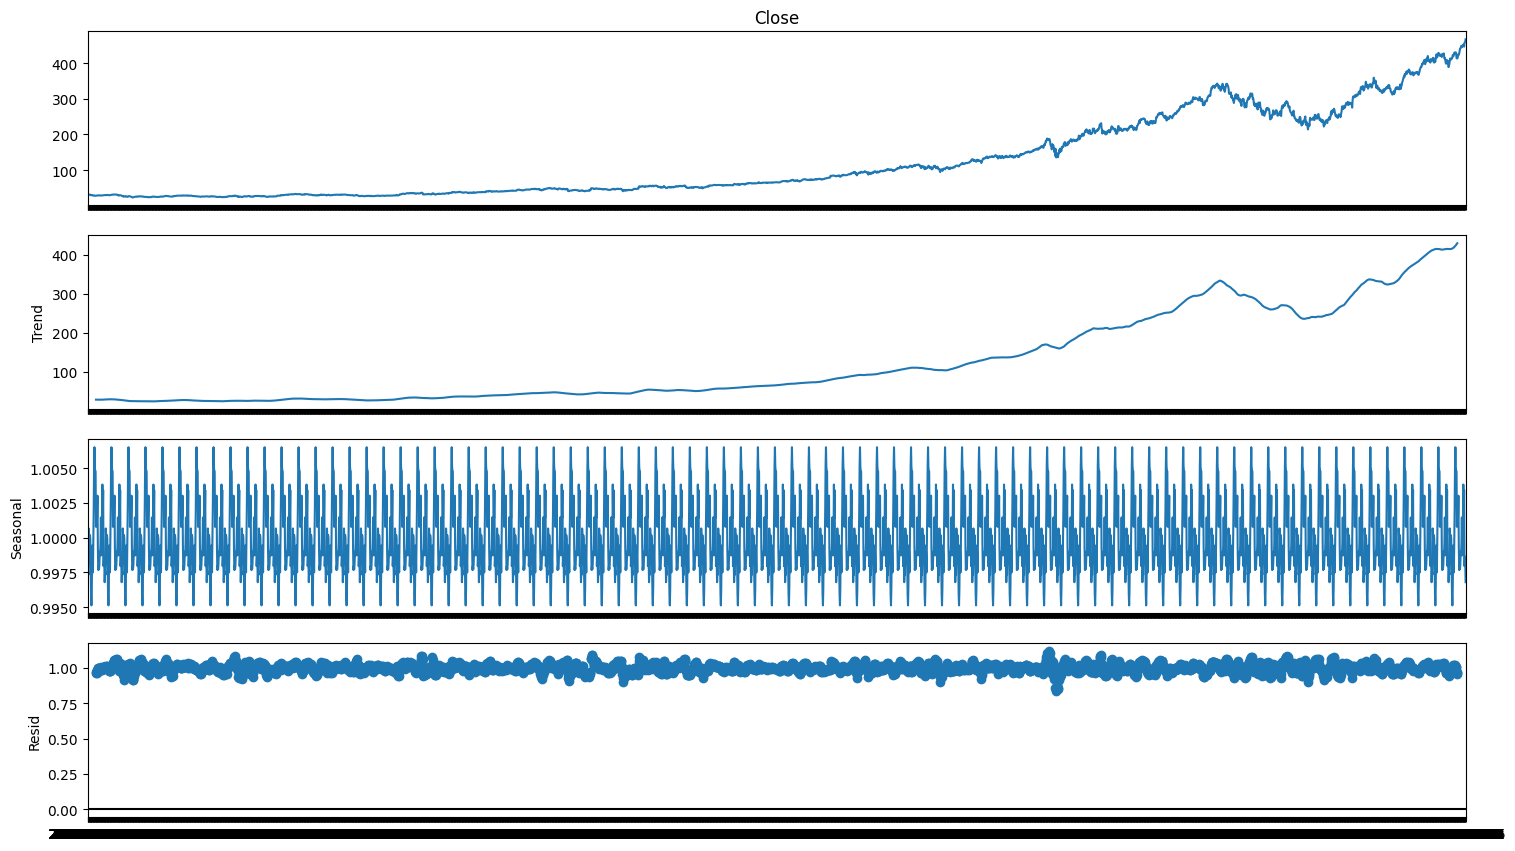

In [13]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
# I have chosen seasonality of 1.5 months (45 days), we can hypertune it to get optimal results
result = seasonal_decompose(stock_data['Close'], model='multiplicative', period = 45)

# check the result time series is statioanry or not? 
result_adf = adfuller(result.resid.dropna())
if(result_adf[1]<0.05): print(f'Stationary because p-value = {result_adf[1]}')
else : print(f'Non Stationary because p-value = {result_adf[1]}')

fig = plt.figure()
fig = result.plot()  
fig.set_size_inches(16, 9)

* result.observed : would contain the original time series data.
* result.trend : would contain the estimated trend component.
* result.seasonal : would contain the estimated seasonal component based on the specified period.
* result.resid : would contain the estimated residual component.

We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

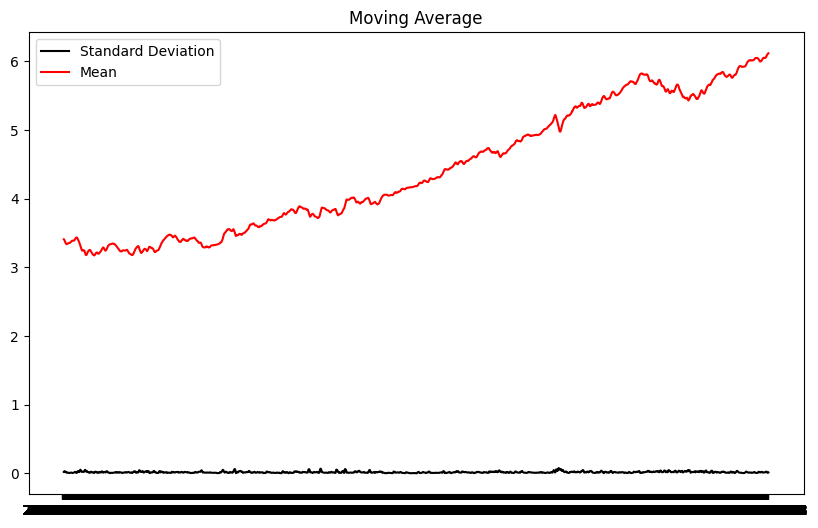

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(stock_data['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

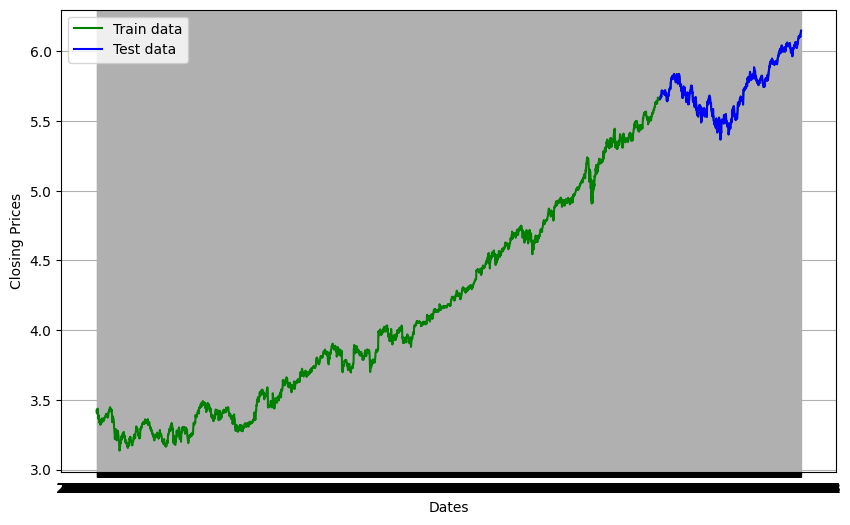

In [9]:
#split data into train and training set

train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

#### Auto ARIMA: Automatically discover the optimal order for an ARIMA model.


The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model.


The **auro_arima** function works by conducting differencing tests (i.e., **Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron**) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the **Canova-Hansen** to determine the optimal order of seasonal differencing, D.

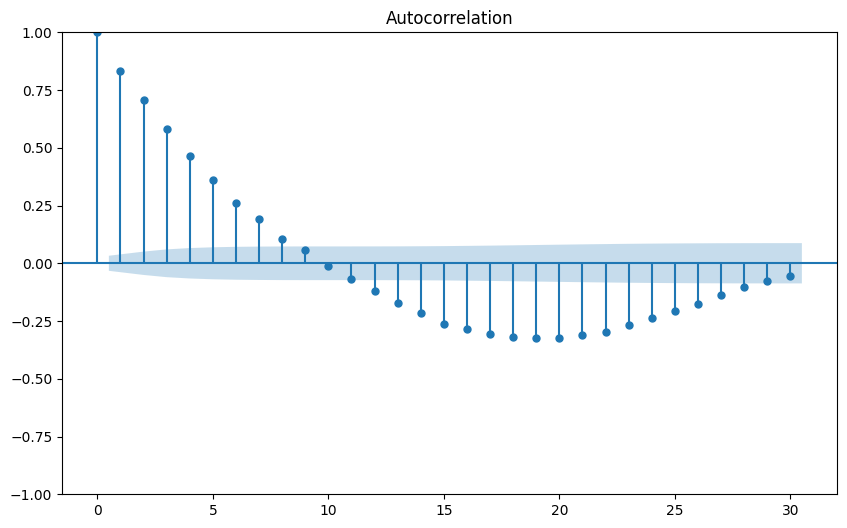

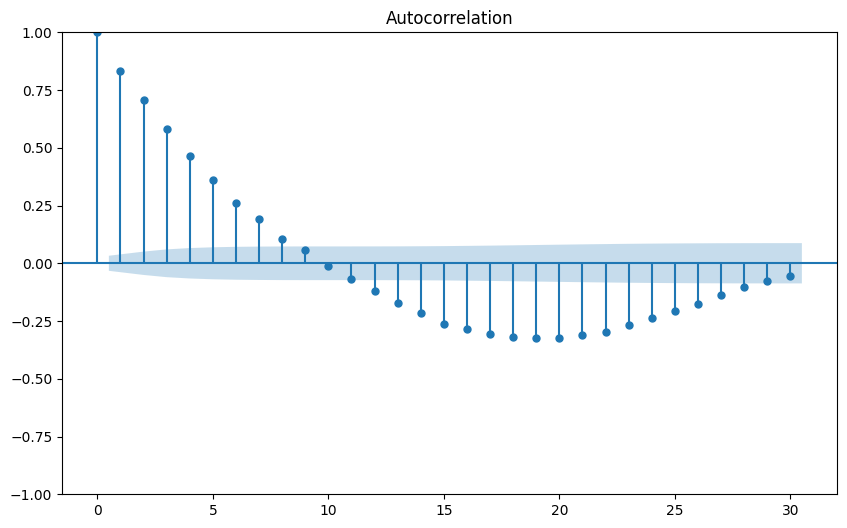

In [17]:
from statsmodels.graphics import tsaplots

tsaplots.plot_acf(result.resid.dropna(), lags = 30)

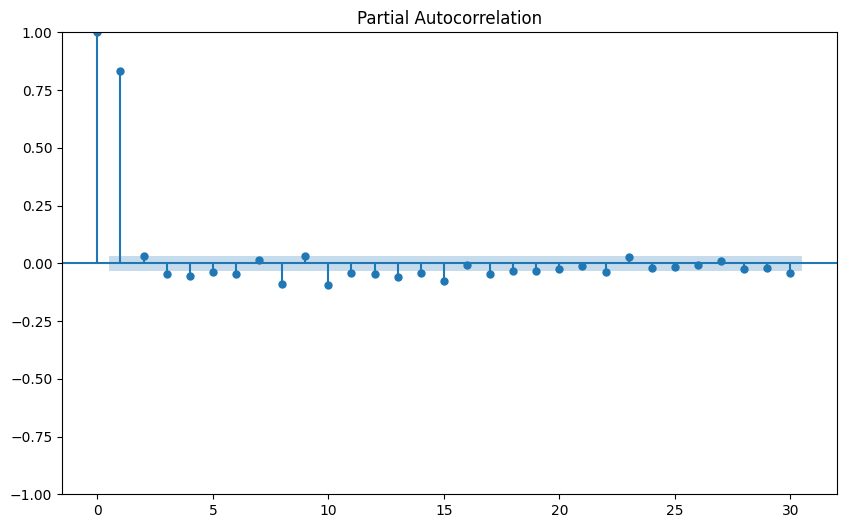

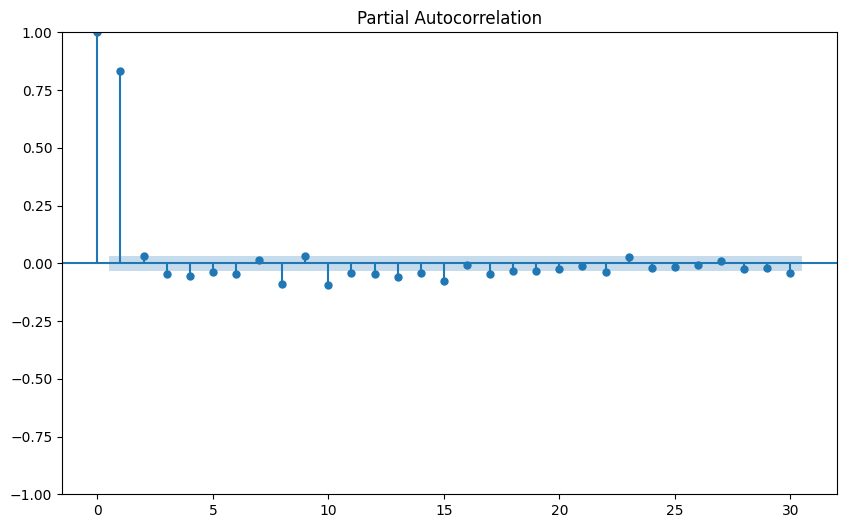

In [15]:
tsaplots.plot_pacf(result.resid.dropna(), lags=30)

#### Let's see if order goes beyond 1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15854.664, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15906.489, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15903.978, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15849.780, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-15905.074, Time=0.80 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-15904.955, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-15903.601, Time=2.95 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-15899.490, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 6.349 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2913
Model:               SARIMAX(1, 1, 0)   Log Likelihood                7956.245
Date:                Mon, 08 Jul 2024   AIC                         -15906.489
Time:               

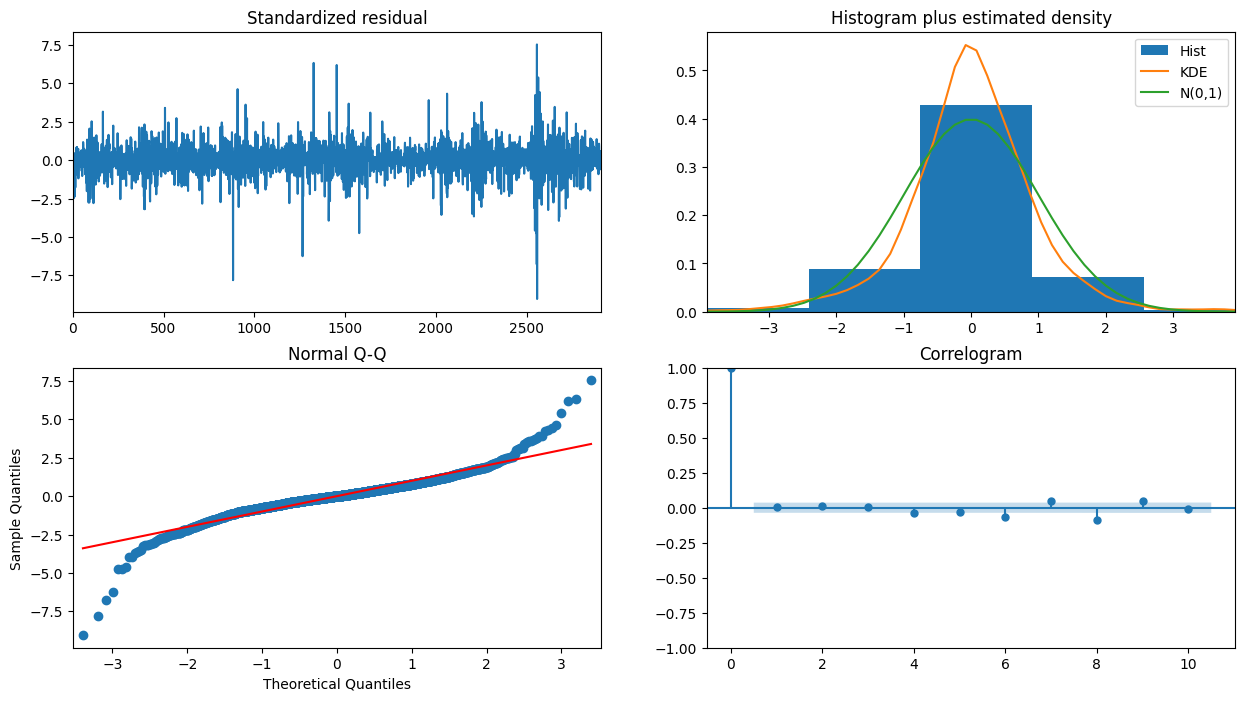

In [10]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

So how to interpret the plot diagnostics?


**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.


**Top Right**: The density plot suggest normal distribution with mean zero.


**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.


**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.


Overall, it seems to be a good fit. Let’s start forecasting the stock prices.


Next, create an ARIMA model with provided optimal parameters p, d and q.

**So the Auto ARIMA model provided the value of p,d, and q as 1, 1 and 0 respectively.**

In [32]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2913
Model:                 ARIMA(1, 1, 0)   Log Likelihood                7951.745
Date:                Mon, 08 Jul 2024   AIC                         -15899.490
Time:                        19:48:18   BIC                         -15887.537
Sample:                             0   HQIC                        -15895.184
                               - 2913                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1327      0.009    -14.912      0.000      -0.150      -0.115
sigma2         0.0002   3.05e-06     81.573      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-